In [1]:
from time import sleep
import matplotlib.pyplot as plt


%matplotlib inline

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

from pettingzoo.classic import connect_four_v3

import pygame

In [2]:
# if GPU is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [3]:
#env = connect_four_v3.env(render_mode="human")
env = connect_four_v3.env()
env.reset()


#Numero de iteraciones
num_episodes = 3000


In [4]:
GAMMA = 0.99
EPS_START = 0.9
EPS_END = 0.05
EPS_DECAY = 0.000001
TAU = 0.0005
LR = 3e-3

In [5]:
# Get number of actions from gym action space
n_actions = 7

# Get the number of state observations
observation, reward, termination, truncation, info = env.last()

#observation_shape = np.array(observation["observation"]).reshape(1,-1)
n_observations = 84




In [6]:
class ActorNetwork(nn.Module):

    def __init__(self, n_observations, n_actions):
        super(ActorNetwork, self).__init__()
        self.layer1 = nn.Linear(n_observations, 128)
        self.layer2 = nn.Linear(128, 128)
        self.layer3 = nn.Linear(128, n_actions)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        return self.layer3(x)

In [7]:
class CriticNetwork(nn.Module):
    def __init__(self, state_size, action_size):
        super(CriticNetwork, self).__init__()
        self.linear1 = nn.Linear(state_size, 128)
        self.linear2 = nn.Linear(128, 128)
        self.linear3 = nn.Linear(128, 1)

    def forward(self, x):
        x = F.relu(self.linear1(x))
        x = F.relu(self.linear2(x))
        return self.linear3(x)

In [8]:
class SAC:
    def __init__(self,name,lr,gamma,tau, eps_start,eps_end,eps_dec, n_observations,n_actions):

        self.name = name
        
        self.lr = lr
        self.gamma = gamma
        self.tau = tau
        self.epsilon = eps_start
        self.eps_end = eps_end
        self.eps_dec = eps_dec
        
        self.n_observations = n_observations
        self.n_actions = n_actions

        self.policy_net = ActorNetwork(n_observations, n_actions).to(device)
        self.policy_optimizer = optim.Adam(self.policy_net.parameters(), lr=LR, amsgrad=True)

        self.critic_net_1 = CriticNetwork(n_observations, n_actions).to(device)
        self.critic_optimizer_1 = optim.Adam(self.critic_net_1.parameters(), lr=LR, amsgrad=True)
        self.critic_net_2 = CriticNetwork(n_observations, n_actions).to(device)
        self.critic_optimizer_2 = optim.Adam(self.critic_net_2.parameters(), lr=LR, amsgrad=True)

        self.target_net_1 = CriticNetwork(n_observations, n_actions).to(device)
        self.target_optimizer_1 = optim.Adam(self.target_net_1.parameters(), lr=LR, amsgrad=True)
        self.target_net_2 = CriticNetwork(n_observations, n_actions).to(device)
        self.target_optimizer_2 = optim.Adam(self.target_net_2.parameters(), lr=LR, amsgrad=True)


        self.memory = []

        self.value_criterion = nn.MSELoss()
        self.criterion_1 = nn.MSELoss()
        self.criterion_2 = nn.MSELoss()
        self.probs = []
        self.loss = 0
        self.actor_loss = 0




    def choose_action(self, agent, state, env):
        if np.random.random() < self.epsilon:
            action = env.action_space(agent).sample(state["action_mask"])
        else:
            action_mask = torch.tensor(state["action_mask"])
            state_tensor = torch.FloatTensor(np.array(state["observation"]).reshape(1,-1))
            
            q_values = self.policy_net(state_tensor)
            max, min= torch.max(q_values), torch.min(q_values)
            q_values = (q_values-min) / (max-min)
            valid_actions = action_mask *  q_values

            print(valid_actions)
            
            # self.probs = valid_actions

            action = np.argmax(valid_actions.detach().numpy())


            #self.policy_net.train()
            self.decrement_epsilon()

        return action
    
    def update(self, state, new_state, reward,done):
        
        
        
        state_tensor = torch.FloatTensor(np.array(state["observation"]).reshape(1,-1))
        new_state_tensor = torch.FloatTensor(np.array(new_state["observation"]).reshape(1,-1))

        next_action_prob = self.policy_net(state_tensor)


        next_q_target_1 = self.target_net_1(new_state_tensor)
        next_q_target_2 = self.target_net_2(new_state_tensor)

        min_next_q_target = torch.min(next_q_target_1, next_q_target_2)
        next_q = (1 * reward) + (1 - done) * self.gamma * (min_next_q_target - next_action_prob)

        Value_1 = self.critic_net_1(state_tensor)  # Doble calculo de la Q-Network
        value_2 = self.critic_net_2(state_tensor)

        loss_1 = self.criterion_1(Value_1,torch.mean(next_q))  # JQ = 𝔼(st,at)~D[0.5(Q1(st,at) - r(st,at) - γ(𝔼st+1~p[V(st+1)]))^2]
        loss_2 = self.criterion_2(value_2,torch.mean(next_q))  # JQ = 𝔼(st,at)~D[0.5(Q1(st,at) - r(st,at) - γ(𝔼st+1~p[V(st+1)]))^2]

        self.loss = (loss_1 + loss_2)/2

        self.policy_optimizer.zero_grad()
        self.critic_optimizer_1.zero_grad()
        self.critic_optimizer_2.zero_grad()
        self.target_optimizer_1.zero_grad()
        self.target_optimizer_2.zero_grad()

        self.loss.backward()
        
        self.policy_optimizer.step()
        self.critic_optimizer_1.step()
        self.critic_optimizer_2.step()
        self.target_optimizer_1.step()
        self.target_optimizer_2.step()




    def update_memory(self,state, reward, termination, truncation, info):
        self.memory.append((state, reward, termination, truncation, info))

    def clear_memory(self):
        self.memory = []


    def optimize(self):
        self.policy_optimizer.zero_grad()
        self.critic_optimizer_1.zero_grad()
        self.critic_optimizer_2.zero_grad()
        self.target_optimizer_1.zero_grad()
        self.target_optimizer_2.zero_grad()
        
        self.policy_optimizer.step()
        self.critic_optimizer_1.step()
        self.critic_optimizer_2.step()
        self.target_optimizer_1.step()
        self.target_optimizer_2.step()
    
    def decrement_epsilon(self):
        self.epsilon = self.epsilon - self.eps_dec \
            if self.epsilon > self.eps_end else self.eps_end
        

    def save_model(self):

        # Path para guardar los agentes entrenados
        PATH = "Agents/" + self.name + ".pt"

        torch.save({
                    'policy_net': self.policy_net.state_dict(),
                    'critic_net_1': self.critic_net_1.state_dict(),
                    'critic_net_2': self.critic_net_2.state_dict(),
                    'target_net_1': self.target_net_1.state_dict(),
                    'target_net_2': self.target_net_2.state_dict(),
                    }, PATH)
    
    def load_model(self):

        # Path donde se encuentran los agentes entrenados
        PATH = "Agents/" + self.name + ".pt"

        checkpoint = torch.load(PATH)

        self.policy_net.load_state_dict(checkpoint['policy_net'])
        self.critic_net_1.load_state_dict(checkpoint['critic_net_1'])
        self.critic_net_2.load_state_dict(checkpoint['critic_net_2'])
        self.target_net_1.load_state_dict(checkpoint['target_net_1'])
        self.target_net_2.load_state_dict(checkpoint['target_net_2'])

        self.policy_net.eval()
        self.critic_net_1.eval()
        self.critic_net_2.eval()
        self.target_net_1.eval()
        self.target_net_2.eval()


In [9]:


sac_agent_0 = SAC(name="agent_0", lr=LR,gamma=GAMMA,tau=TAU,
                eps_start=EPS_START,eps_end=EPS_END,eps_dec=EPS_DECAY,
                n_observations=n_observations,n_actions=n_actions)

sac_agent_1 = SAC(name="agent_1", lr=LR,gamma=GAMMA,tau=TAU,
                eps_start=EPS_START,eps_end=EPS_END,eps_dec=EPS_DECAY,
                n_observations=n_observations,n_actions=n_actions)

sac_agent_a = SAC(name="agent_a", lr=LR,gamma=GAMMA,tau=TAU,
                eps_start=EPS_START,eps_end=EPS_END,eps_dec=EPS_DECAY,
                n_observations=n_observations,n_actions=n_actions)


In [10]:
# Inicializa pygame
#pygame.init()

# Crea la ventana
#screen = pygame.display.set_mode ( (400,400),pygame.RESIZABLE )
#pygame.VIDEORESIZE

agent_0_score = []
agent_1_score = []



total_reward_player_0 = 0
total_reward_player_1 = 0
last_action_player_0 = 0
last_action_player_1 = 0

previous_state = observation

for episode in range(num_episodes):
    state = env.reset()
    
    #Definicion del primer jugador en cada partida
    if(episode % 2 == 1):
        for agent in env.agent_iter():
            
            state, reward, termination, truncation, info = env.last()

            if(agent == "player_0"):
                action = sac_agent_0.choose_action(agent,state,env)
            else:
                action = sac_agent_1.choose_action(agent,state,env)
            
            env.step(action) 

            previous_state = state
            state, reward, termination, truncation, info = env.last()
            

            if termination or truncation:
                    #print(env.rewards)
                    total_reward_player_0 = total_reward_player_0 + env.rewards["player_0"]
                    total_reward_player_1 = total_reward_player_1 + env.rewards["player_1"]
                    
                    agent_0_score.append(total_reward_player_0)
                    agent_1_score.append(total_reward_player_1)
                    
                    sac_agent_0.update(previous_state,state,env.rewards["player_0"],termination)
                    sac_agent_1.update(previous_state,state,env.rewards["player_1"],termination)
                    

                    break
            

        env.close()
    else:
        for agent in env.agent_iter():

            state, reward, termination, truncation, info = env.last()


            if(agent == "player_1"):
                action = sac_agent_0.choose_action(agent,state,env)
            else:
                action = sac_agent_1.choose_action(agent,state,env)

            result = env.step(action) 
            
            previous_state = state
            state, reward, termination, truncation, info = env.last()

            if termination or truncation:
                    total_reward_player_0 = total_reward_player_0 + env.rewards["player_1"]
                    total_reward_player_1 = total_reward_player_1 + env.rewards["player_0"]
                    
                    agent_0_score.append(total_reward_player_0)
                    agent_1_score.append(total_reward_player_1)
                    
                    sac_agent_0.update(previous_state,state,env.rewards["player_1"],termination)
                    sac_agent_1.update(previous_state,state,env.rewards["player_0"],termination)
                    

                    break
        env.close()

print("Total score player 1: " + str(total_reward_player_0))
print("Total score player 2: " + str(total_reward_player_1))


tensor([[0.4554, 0.0000, 1.0000, 0.7052, 0.0000, 0.0000, 0.0000]],
       grad_fn=<MulBackward0>)
tensor([[0.5576, 0.4396, 0.0000, 0.0000, 0.4714, 0.6869, 1.0000]],
       grad_fn=<MulBackward0>)
tensor([[0.4134, 0.0000, 1.0000, 0.8619, 0.1355, 0.3529, 0.3752]],
       grad_fn=<MulBackward0>)
tensor([[0.0000, 0.2487, 0.0000, 0.0879, 0.2432, 0.6208, 1.0000]],
       grad_fn=<MulBackward0>)
tensor([[0.0000, 0.0000, 1.0000, 0.8385, 0.1533, 0.1853, 0.0000]],
       grad_fn=<MulBackward0>)
tensor([[0.6228, 0.0000, 1.0000, 0.8064, 0.2275, 0.4130, 0.6413]],
       grad_fn=<MulBackward0>)
tensor([[0.5128, 0.0000, 1.0000, 0.9236, 0.1641, 0.4674, 0.5662]],
       grad_fn=<MulBackward0>)
tensor([[0.1289, 0.0000, 0.3822, 0.0000, 0.8981, 0.7101, 1.0000]],
       grad_fn=<MulBackward0>)
tensor([[0.5989, 0.0000, 1.0000, 0.9622, 0.2317, 0.2733, 0.0000]],
       grad_fn=<MulBackward0>)
tensor([[0.5350, 0.0000, 0.4111, 0.0000, 0.8468, 0.8501, 0.0000]],
       grad_fn=<MulBackward0>)


c:\Users\koki6\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor([[0.3092, 0.9363, 0.3500, 0.1744, 0.5349, 0.0000, 1.0000]],
       grad_fn=<MulBackward0>)
tensor([[0.4128, 0.0000, 1.0000, 0.8156, 0.1163, 0.2179, 0.5515]],
       grad_fn=<MulBackward0>)
tensor([[0.1957, 0.9406, 0.2739, 0.0222, 0.7258, 0.0000, 1.0000]],
       grad_fn=<MulBackward0>)
tensor([[0.5364, 0.0000, 1.0000, 0.8419, 0.3171, 0.3992, 0.5316]],
       grad_fn=<MulBackward0>)
tensor([[0.4318, 0.0000, 1.0000, 0.8464, 0.2103, 0.5361, 0.4860]],
       grad_fn=<MulBackward0>)
tensor([[0.4313, 0.0000, 1.0000, 0.8173, 0.2955, 0.5048, 0.5645]],
       grad_fn=<MulBackward0>)
tensor([[0.4670, 0.9156, 0.4465, 0.0000, 0.4436, 0.2035, 1.0000]],
       grad_fn=<MulBackward0>)
tensor([[0.0000, 0.4398, 0.3155, 0.0136, 0.1943, 0.2446, 1.0000]],
       grad_fn=<MulBackward0>)
tensor([[0.0266, 0.5090, 0.3921, 0.0000, 0.1419, 0.3549, 1.0000]],
       grad_fn=<MulBackward0>)
tensor([[0.4649, 0.0000, 1.0000, 0.7108, 0.3000, 0.5219, 0.0000]],
       grad_fn=<MulBackward0>)
tensor([[0.0000, 0.0

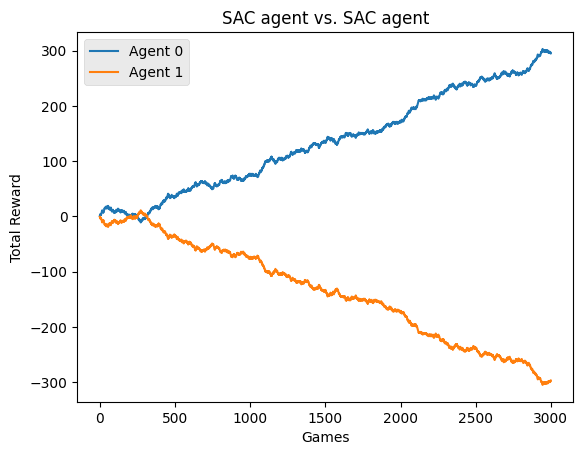

In [11]:
plt.title("SAC agent vs. SAC agent")

plt.ylabel("Total Reward")
plt.xlabel("Games")

plt.style.use("ggplot")
plt.plot(agent_0_score, label="Agent 0")
plt.plot(agent_1_score, label="Agent 1")

plt.legend()
plt.show()

In [12]:
agent_score_a = []
agent_score_r = []

# Jugadores: A (agente solitario) , R (movimientos random)

total_reward_player_a = 0
total_reward_player_r = 0
last_action_player_a = 0
last_action_player_r = 0

env.reset()
previous_state = observation

for episode in range(num_episodes):
    state = env.reset()

    #Definicion del primer jugador en cada partida
    if(episode % 2 == 1):
        for agent in env.agent_iter():
            #print(agent)
            state, reward, termination, truncation, info = env.last()

            if termination or truncation:
                    #print(env.rewards)
                    total_reward_player_a = total_reward_player_a + env.rewards["player_0"]
                    total_reward_player_r = total_reward_player_r + env.rewards["player_1"]

                    sac_agent_a.optimize()
                    
                    agent_score_a.append(total_reward_player_a)
                    agent_score_r.append(total_reward_player_r)

                    sac_agent_a.update(previous_state,state,env.rewards["player_0"],termination)

                    break
            
            if(agent == "player_0"):
                action = sac_agent_a.choose_action(agent,state,env)
                env.step(action)
            else:
                mask = state["action_mask"]
                action = env.action_space(agent).sample(mask)
                env.step(action) 
            previous_state = state
        env.close()
    else:
        for agent in env.agent_iter():
            #print(agent)
            state, reward, termination, truncation, info = env.last()
            
            if(agent == "player_1"):
                action= sac_agent_a.choose_action(agent,state,env)
            else:
                mask = state["action_mask"]
                action = env.action_space(agent).sample(mask)
            
            env.step(action) 
            previous_state = state
            state, reward, termination, truncation, info = env.last()

            if termination or truncation:
                    total_reward_player_a = total_reward_player_a + env.rewards["player_1"]
                    total_reward_player_r = total_reward_player_r + env.rewards["player_0"]

                    sac_agent_a.optimize()
                    
                    agent_score_a.append(total_reward_player_a)
                    agent_score_r.append(total_reward_player_r)

                    sac_agent_a.update(previous_state,state,env.rewards["player_1"],termination)

                    break
        env.close()

print("Total score player 1: " + str(total_reward_player_a))
print("Total score player 2: " + str(total_reward_player_r))

tensor([[0.4119, 0.1639, 0.0000, 1.0000, 0.5261, 0.4205, 0.4704]],
       grad_fn=<MulBackward0>)
tensor([[0.4467, 0.2186, 0.0000, 1.0000, 0.5409, 0.4995, 0.4454]],
       grad_fn=<MulBackward0>)
tensor([[0.5946, 0.4377, 0.0000, 1.0000, 0.5073, 0.9059, 0.3985]],
       grad_fn=<MulBackward0>)
tensor([[0.2824, 0.3264, 0.2283, 1.0000, 0.6017, 0.7836, 0.0000]],
       grad_fn=<MulBackward0>)
tensor([[0.4595, 0.2647, 0.0000, 1.0000, 0.4816, 0.6840, 0.3164]],
       grad_fn=<MulBackward0>)
tensor([[0.4987, 0.3953, 0.0000, 1.0000, 0.4303, 0.8081, 0.1907]],
       grad_fn=<MulBackward0>)
tensor([[0.2176, 0.1852, 0.0000, 1.0000, 0.3631, 0.5939, 0.1160]],
       grad_fn=<MulBackward0>)
tensor([[0.4054, 0.3270, 0.0000, 1.0000, 0.2315, 0.7377, 0.2591]],
       grad_fn=<MulBackward0>)
tensor([[0.3964, 0.3275, 0.0000, 1.0000, 0.5883, 0.7379, 0.4113]],
       grad_fn=<MulBackward0>)
tensor([[0.3116, 0.2399, 0.0000, 1.0000, 0.5743, 0.6718, 0.3520]],
       grad_fn=<MulBackward0>)
tensor([[0.5179, 0.2

c:\Users\koki6\AppData\Local\Programs\Python\Python311\Lib\site-packages\torch\nn\modules\loss.py:536: UserWarning: Using a target size (torch.Size([])) that is different to the input size (torch.Size([1, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)


tensor([[0.4142, 0.2278, 0.0000, 1.0000, 0.5981, 0.6226, 0.5282]],
       grad_fn=<MulBackward0>)
tensor([[0.3295, 0.1372, 0.0000, 1.0000, 0.0000, 0.4677, 0.4467]],
       grad_fn=<MulBackward0>)
tensor([[0.3624, 0.2645, 0.0000, 1.0000, 0.1259, 0.7188, 0.3510]],
       grad_fn=<MulBackward0>)
tensor([[0.0961, 0.1494, 0.0177, 1.0000, 0.3127, 0.4753, 0.0000]],
       grad_fn=<MulBackward0>)
tensor([[0.4573, 0.0679, 0.0000, 1.0000, 0.2562, 0.7663, 0.1004]],
       grad_fn=<MulBackward0>)
tensor([[0.3263, 0.0454, 0.0000, 1.0000, 0.2316, 0.6353, 0.1137]],
       grad_fn=<MulBackward0>)
tensor([[0.5353, 0.2855, 0.0000, 1.0000, 0.5547, 0.6775, 0.3826]],
       grad_fn=<MulBackward0>)
tensor([[0.5077, 0.3238, 0.0000, 1.0000, 0.4871, 0.7180, 0.3340]],
       grad_fn=<MulBackward0>)
tensor([[0.0000, 0.3418, 0.1224, 1.0000, 0.0000, 0.0000, 0.5880]],
       grad_fn=<MulBackward0>)
tensor([[0.5353, 0.2855, 0.0000, 1.0000, 0.5547, 0.6775, 0.3826]],
       grad_fn=<MulBackward0>)
tensor([[0.3131, 0.1

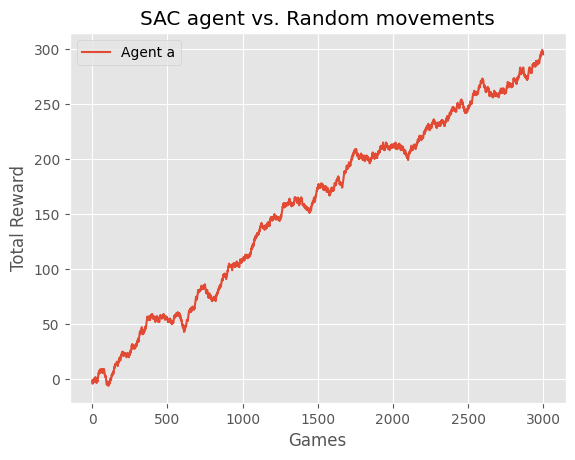

In [13]:
plt.title("SAC agent vs. Random movements")

plt.ylabel("Total Reward")
plt.xlabel("Games")

plt.style.use("ggplot")

plt.plot(agent_score_a, label="Agent a")
plt.legend()
plt.show()

In [14]:
#sac_agent_0.save_model()
#sac_agent_1.save_model()
#sac_agent_a.save_model()

In [15]:
#sac_agent_0.load_model()
#sac_agent_1.load_model()
#sac_agent_a.load_model()

In [16]:
"""
Referencias:

https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
https://pettingzoo.farama.org/content/basic_usage/
https://medium.com/analytics-vidhya/soft-actor-critic-algorithms-in-deep-reinforcement-learning-a11bedd9aa20
https://github.com/haarnoja/sac/blob/master/sac/algos/sac.py
https://github.com/shakti365/soft-actor-critic/blob/master/src/sac.py
https://github.com/pranz24/pytorch-soft-actor-critic/blob/master/sac.py
https://github.com/vwxyzjn/cleanrl/blob/master/cleanrl/sac_continuous_action.py
https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
https://github.com/openai/spinningup/blob/master/spinup/algos/pytorch/sac/core.py
https://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f
https://github.com/yc930401/Actor-Critic-pytorch/blob/master/Actor-Critic.py
https://github.com/chengxi600/RLStuff/blob/master/Actor-Critic/Off-Policy_Actor_Critic.ipynb
https://gist.github.com/jskDr/9173432937ca00755be849f14672e98c
https://www.toptal.com/deep-learning/pytorch-reinforcement-learning-tutorial
https://pylessons.com/Epsilon-Greedy-DQN
https://github.com/Felhof/DiscreteSAC/blob/main/Discrete_SAC_Agent.py
https://github.com/vy007vikas/PyTorch-ActorCriticRL/blob/master/train.py
https://github.com/thomashirtz/soft-actor-critic/tree/main
https://towardsdatascience.com/soft-actor-critic-demystified-b8427df61665
https://towardsdatascience.com/adapting-soft-actor-critic-for-discrete-action-spaces-a20614d4a50a


"""

'\nReferencias:\n\nhttps://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html\nhttps://pettingzoo.farama.org/content/basic_usage/\nhttps://medium.com/analytics-vidhya/soft-actor-critic-algorithms-in-deep-reinforcement-learning-a11bedd9aa20\nhttps://github.com/haarnoja/sac/blob/master/sac/algos/sac.py\nhttps://github.com/shakti365/soft-actor-critic/blob/master/src/sac.py\nhttps://github.com/pranz24/pytorch-soft-actor-critic/blob/master/sac.py\nhttps://github.com/vwxyzjn/cleanrl/blob/master/cleanrl/sac_continuous_action.py\nhttps://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html\nhttps://github.com/openai/spinningup/blob/master/spinup/algos/pytorch/sac/core.py\nhttps://towardsdatascience.com/understanding-actor-critic-methods-931b97b6df3f\nhttps://github.com/yc930401/Actor-Critic-pytorch/blob/master/Actor-Critic.py\nhttps://github.com/chengxi600/RLStuff/blob/master/Actor-Critic/Off-Policy_Actor_Critic.ipynb\nhttps://gist.github.com/jskDr/9173432937ca00755be